In [2]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import cv2
from tensorflow import keras
from keras import backend as K
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam

from tifffile import imread, imwrite

2022-09-27 14:23:03.641061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-27 14:23:03.641116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
#Hyperparameter
img_size=400

epochs = 1000
batch_size = 2
patch_size = img_size
num_batches = 2

scores = [ 0.,  1.,  2.,  3.]
num_classes = len(scores)
classes = np.arange(num_classes)


#Learningrate Schedule
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate
    self.name = 'PolynomialLearningRate'

  def __call__(self, step):
    epoch = step//(num_batches*12.830)
    return self.initial_learning_rate*(1 - epoch/epochs)**0.9
  
  def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "name": self.name,
        }

#Optimizer
optimizer = keras.optimizers.SGD(MyLRSchedule(0.01),momentum=0.99,nesterov=True, name='SGD')

#Loss Function
def combo_loss(targets, prediction):
    
    intersection = K.sum(tf.cast(targets*prediction,tf.float32),axis=(1,2))
    union = (K.sum(targets,axis=(1,2)) + K.sum(prediction,axis=(1,2)))
    dice = 1 - (2./num_classes)*K.sum(intersection/union,axis=1)
    crossentropy = CategoricalCrossentropy()(targets,prediction)

    return dice + crossentropy

In [5]:
def load_label(path_to_label):

    label = cv2.resize(imread(path_to_label),(img_size,img_size),interpolation = cv2.INTER_NEAREST)
    label = to_categorical(label,num_classes)

    return label

In [6]:
def load_training_data(img_names,label_names):
    
    # Initalise mini batch
    images = np.zeros((len(img_names),patch_size,patch_size,3))
    labels = np.zeros((len(label_names),patch_size,patch_size,num_classes))

    for i, (img_name, label_name) in enumerate(zip(img_names, label_names)):

        # append label
        labels[i] = load_label(label_name)

        # append image
        new_img = cv2.resize(cv2.imread(img_name),(400,400)).astype(np.float32)
        new_img -= np.mean(new_img)
        new_img /= np.var(new_img)
        images[i] = new_img

    return images, labels

In [7]:
#Training Data
train_img_path = '/home/jacob-relle/Dokumente/AML Projekt/cropped_images/800/train'
train_label_path = '/home/jacob-relle/Dokumente/AML Projekt/deepdart_data_ring/train'


    # get filenames
train_img_names = sorted(glob.glob(train_img_path+'/**/*'+'.JPG', recursive=True))
train_label_names = sorted(glob.glob(train_label_path+'/**/*'+'.tif', recursive=True))

train_img_list = [train_img_names[i:i + num_batches*batch_size] for i in range(0, len(train_img_names), num_batches*batch_size)]
train_label_list = [train_label_names[i:i + num_batches*batch_size] for i in range(0, len(train_label_names), num_batches*batch_size)]


#Validation Data
val_img_path = '/home/jacob-relle/Dokumente/AML Projekt/cropped_images/800/val'
val_label_path = '/home/jacob-relle/Dokumente/AML Projekt/deepdart_data_ring/val'

    # get filenames
val_img_names = sorted(glob.glob(val_img_path+'/**/*'+'.JPG', recursive=True))
val_label_names = sorted(glob.glob(val_label_path+'/**/*'+'.tif', recursive=True))

val_img_list = [val_img_names[i:i + num_batches*batch_size] for i in range(0, len(val_img_names), num_batches*batch_size)]
val_label_list = [val_label_names[i:i + num_batches*batch_size] for i in range(0, len(val_label_names), num_batches*batch_size)]

In [8]:
from keras.layers import MaxPooling2D, Conv2D, Conv2DTranspose, concatenate ,BatchNormalization, LeakyReLU

Norm = BatchNormalization
LReLU = LeakyReLU
Pool = MaxPooling2D

def NN_UNet():
    with tf.device("cpu:0"):
        inputs = keras.Input(shape=(patch_size,patch_size,3))

        ###Contracting Part
        ##First Block
        x = Conv2D(32,3,padding='same')(inputs)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(32,3,padding='same')(x)
        x = Norm()(x)
        l1 = LReLU(alpha= 0.01)(x)

        x = Pool(pool_size=2, strides= 2, padding='valid')(l1)
        ##Second Block
        x = Conv2D(64,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(64,3,padding='same')(x)
        x = Norm()(x)
        l2 = LReLU(alpha= 0.01)(x)

        x = Pool(pool_size= 2, strides= 2, padding='valid')(l2)
        ##Third Block
        x = Conv2D(128,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(128,3,padding='same')(x)
        x = Norm()(x)
        l3 = LReLU(alpha= 0.01)(x)
        
        x = Pool(pool_size= 2, strides= 2, padding='valid')(l3)
        ##Fourth Block
        x = Conv2D(256,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(256,3,padding='same')(x)
        x = Norm()(x)
        l4 = LReLU(alpha= 0.01)(x)

        x = Pool(pool_size= 2, strides= 2, padding='valid')(l4)



        ##Bottleneck
        x = Conv2D(512,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(512,3,padding='same')(x)
        x = Norm()(x)
        l5 = LReLU(alpha= 0.01)(x)
    

        ###Expansive Part
        ##Fourth Block
        x = Conv2DTranspose(256,3,2,padding='same')(l5)
        x = concatenate([x,l4])
        
        x = Conv2D(256,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(256,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        ##Third Block
        x = Conv2DTranspose(128,3,2,padding='same')(x)
        x = concatenate([x,l3])
        
        x = Conv2D(128,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(128,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)
        
        ##Second Block
        x = Conv2DTranspose(64,3,2,padding='same')(x)
        x = concatenate([x,l2])

        x = Conv2D(64,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(64,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        #First Block
        x = Conv2DTranspose(32,3,2,padding='same')(x)
        x = concatenate([x,l1])

        x = Conv2D(32,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        x = Conv2D(32,3,padding='same')(x)
        x = Norm()(x)
        x = LReLU(alpha= 0.01)(x)

        #Final Layer
        x = Conv2D(num_classes,1)(x)
        outputs = keras.activations.softmax(x)

        model = keras.Model(inputs,outputs,name='ringnet')
        return model

UNet = NN_UNet()
UNet.summary()


2022-09-27 14:23:34.094462: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-27 14:23:34.094530: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Murasame): /proc/driver/nvidia/version does not exist
2022-09-27 14:23:34.098286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "ringnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 400, 400, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
current_epoch = 0
current_batch = 0

In [ ]:
UNet.compile(
    loss = combo_loss,
    optimizer = optimizer,
    metrics=["accuracy"]
)

for epoch in range(current_epoch,epochs):
    print(f'=======================Start of Epoch {epoch+1}==========================\n')
    
    for i in range(current_batch,len(train_img_list)):
        #load the data to train and validate
        x_train, y_train = load_training_data(train_img_list[i],train_label_list[i])
        val_i = i % len(val_img_list)
        x_val, y_val = load_training_data(val_img_list[val_i],val_label_list[val_i])
        with tf.device("cpu:0"):
            history = UNet.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=epoch+1,initial_epoch=epoch,verbose=1,validation_data=(x_val,y_val))
        # Log every 5 batches.
        if i % 5 == 0:
            print(f"Progress: {((i + 1) * batch_size*num_batches)}/{len(train_img_names)} Steps"  )
            UNet.save_weights('ring.h5')
        current_batch +=1
    current_batch = 0
    current_epoch +=1

In [9]:
UNet.load_weights("./ring_best.h5")

In [16]:
x_val, y_val = load_training_data(val_img_list[0],val_label_list[0])
val = UNet.predict(x_val)[1]
val = np.argmax(val,axis=2)

1/1 [==============================] - 3s 3s/step


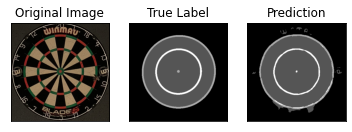

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.imshow(plt.imread(val_img_list[0][0]))
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title('Original Image')

ax2.imshow(np.dot(y_val[0],scores),cmap='gray')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title('True Label')

ax3.imshow(val,cmap='gray')
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title('Prediction')
plt.savefig("ring_trained.png", dpi=300)
plt.show()